In [2]:
import time
import numpy as np
import torch
from torch import nn

# For classes
import inspect 
import matplotlib.pyplot as plt
import collections

### Three classes

* **Module**: Contains models, losses, and optimzation methods
* **DataModule**: Data Loaders for training and validation
* **Trainer**: train models on a variety of hardware platforms

In [3]:
class A:
    def __init__(self):
        self.b = 1

    def do(self):
        print (f'Class attribute "b" is {self.b}')


a = A()
a.do()

Class attribute "b" is 1


In [4]:
class HyperParameters:
    '''Parent class to save parameters not ignored'''

    # Save paremeters not ignored to self
    # See HyperparametersMixin from Pytorch Lightning API
    def save_hyperparameters(self, * args, ignore=[]):

        # Get local variables passed to function (a=b,...) -> {a:b,...}
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)

        # Get parameters not ignored and place in dictionary
        self.hparams = {k: v for k, v in local_vars.items() if k not in
                        set(ignore + ['self']) and not k.startswith('_')}

        # Save parameter values to self. {a:b} -> self.a = b
        for k, v in self.hparams.items():
            setattr(self, k, v)


# Instance of HyperParameters accepting three values
class B(HyperParameters):
    def __init__(self, a, b, c):
        self.save_hyperparameters(ignore=['c'])
        print(f'{self.a = }\n{self.b = }')
        print(f"There is no self.c = {not hasattr(self, 'c')}")


class ProgressBoard(HyperParameters):  # @save
    """Plot data points in animation."""

    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):

        # Create named tuple Point
        Point = collections.namedtuple('Point', ['x', 'y'])

        # If new data, make dictionary for points and data
        if not hasattr(self, 'raw_points'):
            # Make an ordered dictionary
            self.raw_points = collections.OrderedDict()
            self.data = collections.OrderedDict()

        # If no data, initialize data with an array
        if label not in self.raw_points:
            self.raw_points[label] = []
            self.data[label] = []

        # Get current data and append new data
        points = self.raw_points[label]
        line = self.data[label]
        points.append(Point(x, y))
        # print (self.raw_points, self.data)
        # Return if not every_n
        if len(points) != every_n:
            return

        # calculate the mean for line
        def mean(x): return sum(x) / len(x)
        line.append(Point(mean([p.x for p in points]),
                          mean([p.y for p in points])))

        points.clear()
        if self.fig is None:
            self.fig = plt.figure()
        plt_lines, labels = [], []

        for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
            plt_lines.append(plt.plot([p.x for p in v],
                                      [p.y for p in v], linestyle=ls, color=color)[0])
            labels.append(k)
        axes = plt.gca()
        if self.ylim: axes.set_ylim(self.ylim)
        if not self.xlabel: self.xlabel = self.x
        axes.set_xlabel(self.xlabel)
        axes.set_ylabel(self.ylabel)
        axes.set_xscale(self.xscale)
        axes.set_yscale(self.yscale)
        axes.legend(plt_lines, labels)




b = B(a=1, b=2, c=3)


self.a = 1
self.b = 2
There is no self.c = True


In [5]:
class Module(HyperParameters):
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):
        assert hasattr(self, 'trainer'), 'Trainer is not initiated'
        self.board.xlabel = 'epoch'

        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))

        def training_step(self, batch):
            l = self.loss(self(*batch[:-1]), batch[-1])
            self.plot('loss', l, train=True)
            return l

        def validation_step(self, batch):
            l = self.loss(self(*batch[:-1]), batch[-1])
            self.plot('loss', l, train=False)

        def configure_optimizers(self):
            raise NotImplementedError


mod = Module()
mod.hparams


{'plot_train_per_epoch': 2, 'plot_valid_per_epoch': 1}

In [126]:
class DataModule(HyperParameters):
    def __init__(self, root='data', num_workers=4):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError
    
    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

dm = DataModule()
dm.hparams

{'root': 'data', 'num_workers': 4}

In [129]:
class Trainer(HyperParameters):
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
    
    def fit_epoch(self):
        raise NotImplementedError

tn = Trainer(10)
tn.hparams

{'max_epochs': 10, 'num_gpus': 0, 'gradient_clip_val': 0}

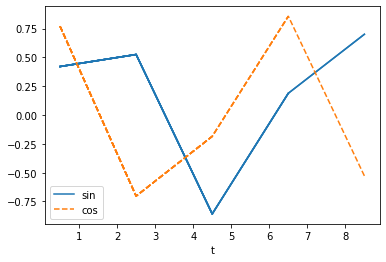

In [118]:
board = ProgressBoard('t')
for x in np.arange(0, 10,1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=2)

odict_items([('sin', [Point(x=0.1, y=0.09933466539753061), Point(x=0.5, y=0.47703040785184303)]), ('cos', [Point(x=0.1, y=0.9900332889206208), Point(x=0.5, y=0.8731983044562817)]), ('test', [Point(x=1.0, y=2.0)])])


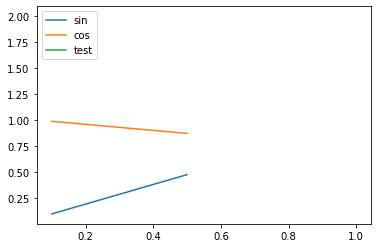

In [83]:
board.draw(x=1,y=2,label='test')


In [37]:
Point = collections.namedtuple('Point', ['x', 'y'])

p = Point(11, y=22)
p[0] + p[1]

x, y = p
x, y

p.x + p.y
p

p.clear()

AttributeError: 'Point' object has no attribute 'clear'

In [39]:
d = collections.OrderedDict.fromkeys('abcde')
print (d)
d.move_to_end('b')
print (d)
''.join(d)

d.clear()
d


OrderedDict([('a', None), ('b', None), ('c', None), ('d', None), ('e', None)])
OrderedDict([('a', None), ('c', None), ('d', None), ('e', None), ('b', None)])


OrderedDict()

In [114]:
fig = plt.figure()
plt.get_fignums()
fig = plt.figure()
plt.get_fignums()


[1, 2]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

[]